# deTACTer 전술 탐지 결과 분석

이 노트북은 OPTICS와 Agglomerative 두 클러스터링 알고리즘의 결과를 비교 분석합니다.

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 경로
DATA_DIR = 'c:/Users/Public/Documents/DIK/deTACTer/data/refined/v3.2/'

print('라이브러리 로드 완료!')

라이브러리 로드 완료!


## 1. 데이터 로드

In [4]:
# 시퀀스 데이터
seq_df = pd.read_csv(DATA_DIR + 'attack_sequences.csv', encoding='utf-8-sig')
stats_df = pd.read_csv(DATA_DIR + 'attack_sequences_stats.csv', encoding='utf-8-sig')

# 클러스터링 결과
cluster_df = pd.read_csv(DATA_DIR + 'cluster_labels.csv', encoding='utf-8-sig')
optics_stats = pd.read_csv(DATA_DIR + 'optics_cluster_stats.csv', encoding='utf-8-sig', index_col=0)
agglom_stats = pd.read_csv(DATA_DIR + 'agglom_cluster_stats.csv', encoding='utf-8-sig', index_col=0)

print(f'시퀀스 데이터: {len(seq_df):,} rows')
print(f'클러스터링 대상: {len(cluster_df):,} 시퀀스')
print(f'OPTICS 클러스터 수: {len(optics_stats)}')
print(f'Agglomerative 클러스터 수: {len(agglom_stats)}')

시퀀스 데이터: 2,920 rows
클러스터링 대상: 415 시퀀스
OPTICS 클러스터 수: 7
Agglomerative 클러스터 수: 10


## 2. OPTICS vs Agglomerative 클러스터 비교

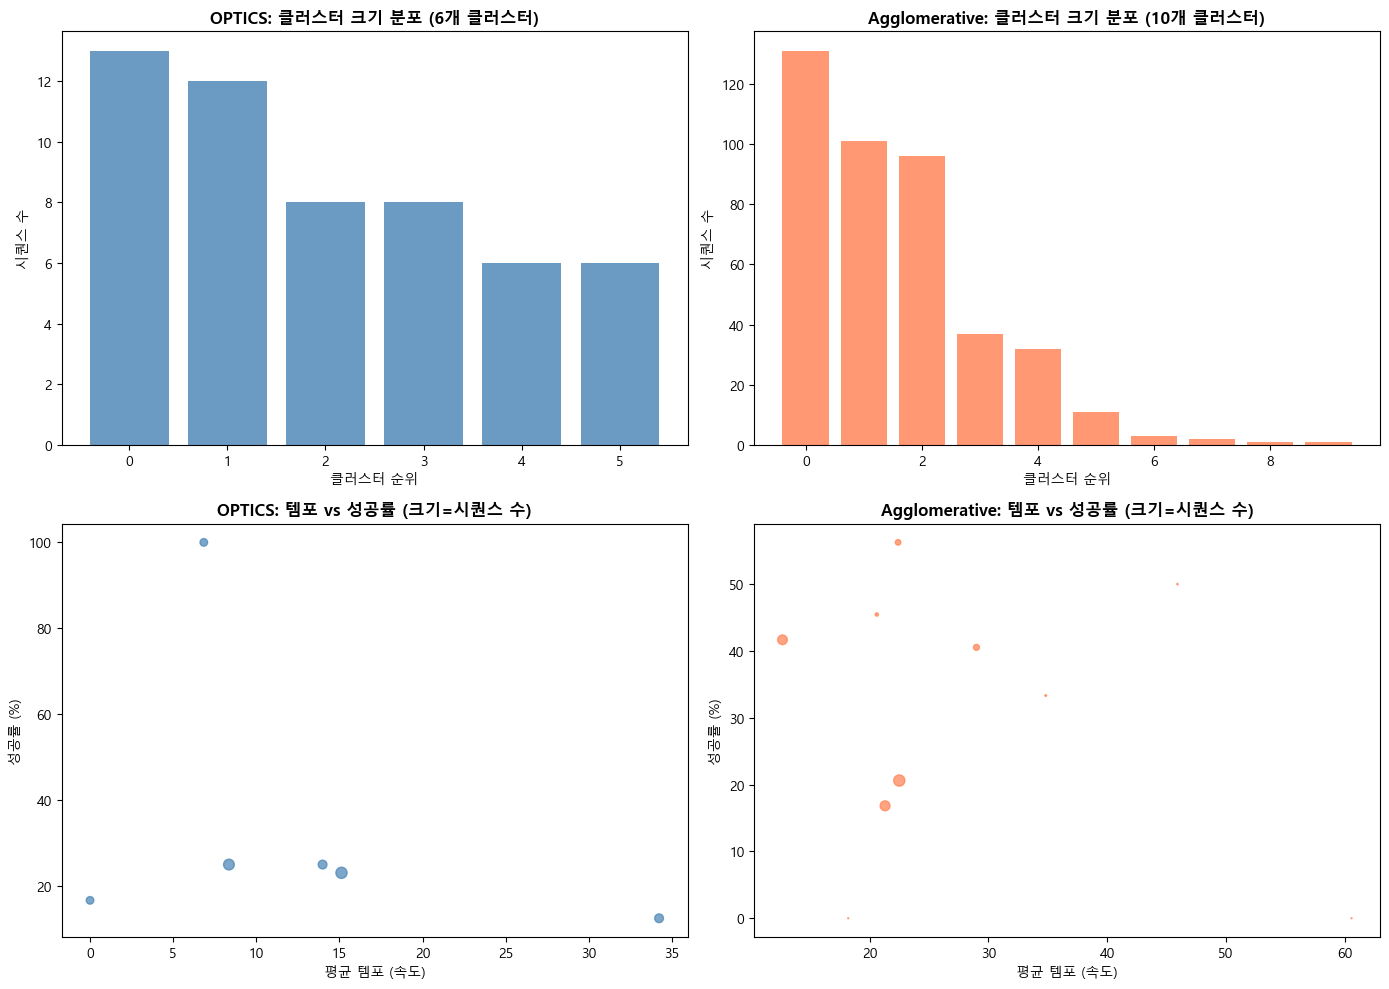

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# OPTICS 클러스터 크기 분포
optics_valid = optics_stats[optics_stats.index != -1].sort_values('count', ascending=False)
axes[0, 0].bar(range(len(optics_valid)), optics_valid['count'].values, color='steelblue', alpha=0.8)
axes[0, 0].set_xlabel('클러스터 순위')
axes[0, 0].set_ylabel('시퀀스 수')
axes[0, 0].set_title(f'OPTICS: 클러스터 크기 분포 ({len(optics_valid)}개 클러스터)', fontweight='bold')

# Agglomerative 클러스터 크기 분포
agglom_sorted = agglom_stats.sort_values('count', ascending=False)
axes[0, 1].bar(range(len(agglom_sorted)), agglom_sorted['count'].values, color='coral', alpha=0.8)
axes[0, 1].set_xlabel('클러스터 순위')
axes[0, 1].set_ylabel('시퀀스 수')
axes[0, 1].set_title(f'Agglomerative: 클러스터 크기 분포 ({len(agglom_sorted)}개 클러스터)', fontweight='bold')

# OPTICS 템포 vs 성공률
axes[1, 0].scatter(optics_valid['avg_tempo'], optics_valid['success_rate'] * 100, 
                   s=optics_valid['count'] * 5, alpha=0.7, c='steelblue')
axes[1, 0].set_xlabel('평균 템포 (속도)')
axes[1, 0].set_ylabel('성공률 (%)')
axes[1, 0].set_title('OPTICS: 템포 vs 성공률 (크기=시퀀스 수)', fontweight='bold')

# Agglomerative 템포 vs 성공률
axes[1, 1].scatter(agglom_sorted['avg_tempo'], agglom_sorted['success_rate'] * 100, 
                   s=agglom_sorted['count'] / 2, alpha=0.7, c='coral')
axes[1, 1].set_xlabel('평균 템포 (속도)')
axes[1, 1].set_ylabel('성공률 (%)')
axes[1, 1].set_title('Agglomerative: 템포 vs 성공률 (크기=시퀀스 수)', fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR + '../cluster_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. 클러스터 통계 상세

In [6]:
print('=== OPTICS 클러스터 통계 (노이즈 제외) ===')
display(optics_valid.head(10))

=== OPTICS 클러스터 통계 (노이즈 제외) ===


,count,avg_tempo,avg_duration,avg_distance,success_rate
optics_cluster,,,,,
3,13,15.121725,6.808692,0.371418,0.230769
4,12,8.356042,2.688333,0.400564,0.250000
1,8,13.985048,5.025750,0.143865,0.250000
5,8,34.214922,6.509875,0.418785,0.125000
0,6,6.844341,7.417333,0.457016,1.000000
2,6,0.004481,38.217833,0.751948,0.166667


In [7]:
print('=== Agglomerative 클러스터 통계 ===')
display(agglom_sorted)

=== Agglomerative 클러스터 통계 ===


,count,avg_tempo,avg_duration,avg_distance,success_rate
agglom_cluster,,,,,
5,131,22.493773,15.355378,0.798291,0.206107
6,101,21.296429,10.911490,0.768821,0.168317
2,96,12.654117,13.981229,0.455204,0.416667
3,37,28.993489,17.020676,1.131916,0.405405
0,32,22.389945,16.695250,1.095616,0.562500
1,11,20.597331,10.613318,1.303540,0.454545
4,3,34.831365,14.902000,1.561262,0.333333
7,2,45.927627,11.148000,1.292607,0.500000
8,1,60.593386,8.668000,1.216910,0.000000


## 4. 축구장 위 전술 패턴 시각화

각 클러스터의 대표 시퀀스를 축구장 위에 시각화합니다.

In [8]:
def draw_pitch(ax):
    """정규화된 좌표(0~1)에 맞춘 축구장을 그립니다."""
    ax.set_facecolor('#1a472a')
    
    # 외곽선
    ax.plot([0, 1], [0, 0], color='white', linewidth=2)
    ax.plot([0, 1], [1, 1], color='white', linewidth=2)
    ax.plot([0, 0], [0, 1], color='white', linewidth=2)
    ax.plot([1, 1], [0, 1], color='white', linewidth=2)
    ax.plot([0.5, 0.5], [0, 1], color='white', linewidth=1.5)
    
    # 패널티 박스
    ax.add_patch(patches.Rectangle((0, 0.211), 0.157, 0.578, fill=False, color='white', linewidth=1.5))
    ax.add_patch(patches.Rectangle((0.843, 0.211), 0.157, 0.578, fill=False, color='white', linewidth=1.5))
    
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
    ax.axis('off')
    return ax

def plot_sequence(ax, seq_df, seq_id, color='yellow', alpha=0.8):
    """단일 시퀀스의 경로를 그립니다."""
    seq = seq_df[seq_df['sequence_id'] == seq_id].sort_values('seq_position', ascending=False)
    x = seq['start_x'].values
    y = seq['start_y'].values
    ax.plot(x, y, color=color, alpha=alpha, linewidth=2, marker='o', markersize=4)
    ax.scatter([x[0]], [y[0]], color='lime', s=80, zorder=5, edgecolor='white')
    ax.scatter([x[-1]], [y[-1]], color='red', s=80, zorder=5, edgecolor='white', marker='*')
    return ax

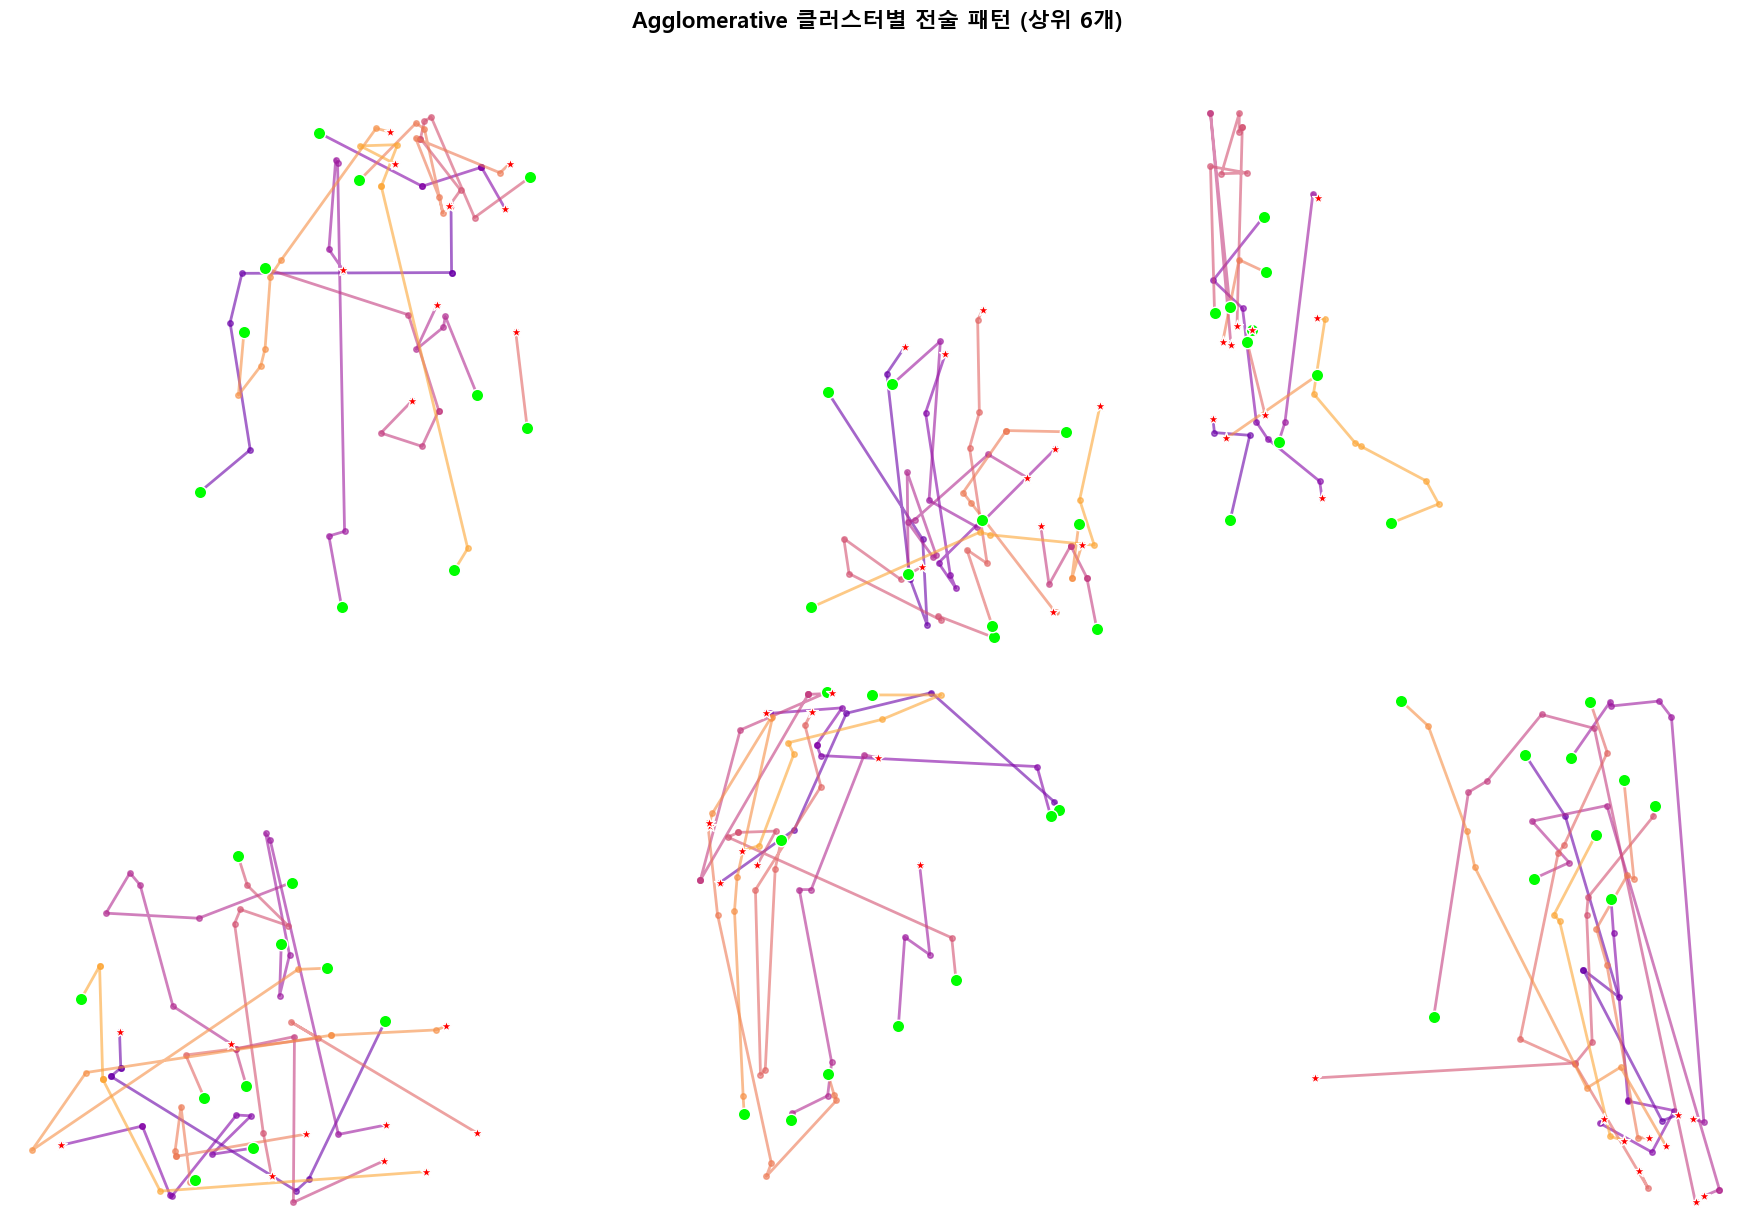

In [9]:
# Agglomerative 상위 6개 클러스터 시각화
top_clusters = agglom_sorted.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, cluster_id in enumerate(top_clusters):
    ax = draw_pitch(axes[i])
    
    # 해당 클러스터의 시퀀스들
    seq_ids = cluster_df[cluster_df['agglom_cluster'] == cluster_id]['sequence_id'].values[:10]
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(seq_ids)))
    
    for j, seq_id in enumerate(seq_ids):
        plot_sequence(ax, seq_df, seq_id, color=colors[j], alpha=0.6)
    
    stats = agglom_stats.loc[cluster_id]
    ax.set_title(f'클러스터 {cluster_id} (n={int(stats["count"])}, 템포={stats["avg_tempo"]:.1f}, 성공률={stats["success_rate"]*100:.1f}%)', 
                 fontsize=11, fontweight='bold', color='white')

plt.suptitle('Agglomerative 클러스터별 전술 패턴 (상위 6개)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(DATA_DIR + '../agglom_tactical_patterns.png', dpi=150, bbox_inches='tight', facecolor='#1a472a')
plt.show()

## 5. 알고리즘 비교 결론

In [10]:
print('='*60)
print('알고리즘 비교 요약')
print('='*60)

print(f'\n[OPTICS]')
print(f'  - 클러스터 수: {len(optics_valid)}개 (노이즈 {optics_stats.loc[-1, "count"] if -1 in optics_stats.index else 0}개 제외)')
print(f'  - 장점: 노이즈(특이 패턴) 자동 감지, 클러스터 수 자동 결정')
print(f'  - 단점: 대부분이 노이즈로 분류됨 (파라미터 튜닝 필요)')

print(f'\n[Agglomerative]')
print(f'  - 클러스터 수: {len(agglom_stats)}개 (사전 지정)')
print(f'  - 장점: 명확한 클러스터 분리, 해석 용이')
print(f'  - 단점: 클러스터 수를 미리 지정해야 함')

print('\n' + '='*60)
print('권장: 초기 탐색에는 Agglomerative, 이상값 탐지에는 OPTICS')
print('='*60)

알고리즘 비교 요약

[OPTICS]
  - 클러스터 수: 6개 (노이즈 362개 제외)
  - 장점: 노이즈(특이 패턴) 자동 감지, 클러스터 수 자동 결정
  - 단점: 대부분이 노이즈로 분류됨 (파라미터 튜닝 필요)

[Agglomerative]
  - 클러스터 수: 10개 (사전 지정)
  - 장점: 명확한 클러스터 분리, 해석 용이
  - 단점: 클러스터 수를 미리 지정해야 함

권장: 초기 탐색에는 Agglomerative, 이상값 탐지에는 OPTICS


---
## 끝

추가 분석이나 특정 클러스터의 상세 분석이 필요하면 요청해주세요!